# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions through different means

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
import mne
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)
cpus = 5 #if not enough RAM to load all participants data, better reduce the number of processes

%load_ext autoreload
%autoreload 2


16


# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
hsmm.read_mne_EEG#Note the use of filtering and minimum and minimum both for epoch size and RTs, default values will likely not always be a good fit

<function pyhsmm_mvpa.read_mne_EEG(pfiles, event_id, resp_id, sfreq, events=None, tmin=-0.2, tmax=5, offset_after_resp=0.1, low_pass=0.5, high_pass=30, upper_limit_RT=5, lower_limit_RT=0.001, reject_threshold=None)>

In [3]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
sfreq = 100#For resampling

path = '/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
print(subj_names)
subj_files = [path+ 'preprocessed_'+x+'.fif' for x in subj_names]

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    with multiprocessing.Pool(processes=cpus) as pool:
        epoch_data = pool.starmap(hsmm.read_mne_EEG, 
        zip([[x] for x in subj_files], itertools.repeat(event_id), itertools.repeat(resp_id),    
                itertools.repeat(sfreq), itertools.repeat(None), itertools.repeat(-.25), itertools.repeat(2), 
                itertools.repeat(.05), itertools.repeat(1), itertools.repeat(30), itertools.repeat(2), 
                itertools.repeat(.25)))
    
    epoch_data = xr.concat(epoch_data, pd.Series(subj_names, name="participant"),
                          fill_value={'event':'', 'data':np.nan})#not sure about the order of the particiapnt use with caution
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position
raw.set_montage(mne.channels.make_standard_montage('biosemi64'))

['S6', 'S18', 'S20', 'S1', 'S16', 'S14', 'S7', 'S15', 'S2', 'S3', 'S4', 'S5', 'S17', 'S10', 'S8', 'S12', 'S9', 'S11', 'S13']


/tmp/ipykernel_62471/3332051891.py:29: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position


<Raw | preprocessed_S6.fif, 72 x 4594688 (4487.0 s), ~101 kB, data not loaded>

In [4]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 2370, samples: 200, participant: 19, electrodes: 64)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2364 2365 2366 2367 2368 2369
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) object 'S6' 'S18' 'S20' 'S1' ... 'S9' 'S11' 'S13'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    100.0

## Applying standardization, variance scaling and PCA

In [5]:
hsmm_dat, PCs, explained_var, means = hsmm.transform_data(epoch_data,'participant',return_weights=True, n_comp=10)

# Applying HsMM for all conditions

Initializing model

In [6]:
hsmm_data = hsmm.stack_data(hsmm_dat,'participant')
init = hsmm.hsmm(hsmm_data.data.T, hsmm_data.starts.data, hsmm_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [7]:
bests = init.backward_estimation(max_starting_points=20)
bests

Estimating all solutions for maximal number of bumps (5) with 19 random starting points
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5,
                  samples: 200, trial: 41169)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.745e+05 -1.456e+05 ... -1.732e+05
    parameters   (n_bumps, stage, params) float64 2.0 2.904 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.7507 0.6247 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

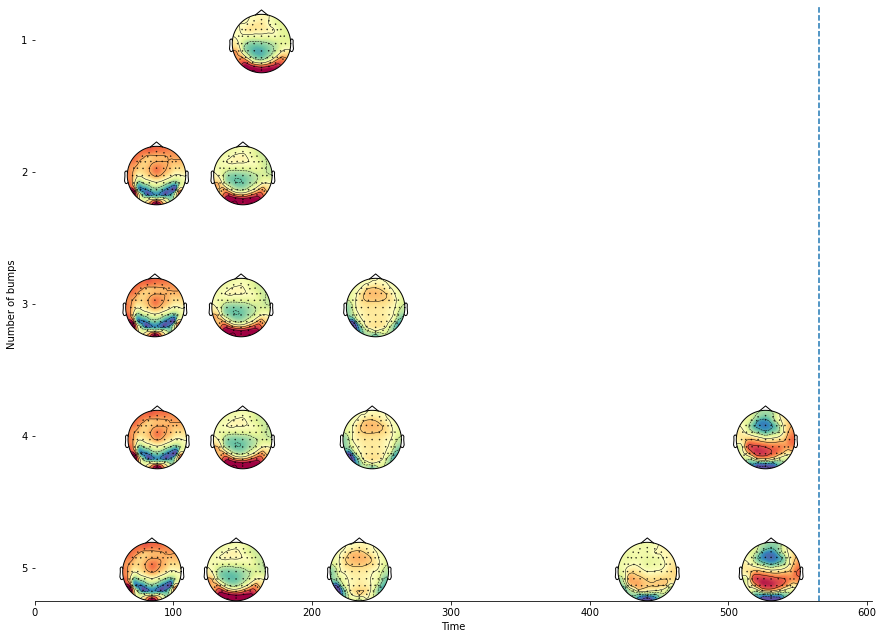

In [8]:
electrodes = xr.DataArray(hsmm.reconstruct(bests.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.plot_topo_timecourse(electrodes, init.mean_bump_times(bests.eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=init.bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(hsmm_data.ends.data - hsmm_data.starts.data), 
                          figsize=(15,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

In [9]:
temp = hsmm_data.unstack().data

subjects_idx = epoch_data.participant.values
likelihoods_loo = []

all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})


KeyboardInterrupt: 

In [ ]:
hsmm.plot_LOOCV(loocv)

# Estimating separate magnitudes for left and right stimulus (expecting left and right LRPs)

In [10]:
subset = hsmm_dat.where(epoch_data.event.str.contains('left'),drop=True)
hsmm_l_data = hsmm.stack_data(subset,'participant')
init_l = hsmm.hsmm(hsmm_l_data.data.T, hsmm_l_data.starts.data, hsmm_l_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

subset = hsmm_dat.where(epoch_data.event.str.contains('right'),drop=True)
hsmm_r_data = hsmm.stack_data(subset,'participant')
init_r = hsmm.hsmm(hsmm_r_data.data.T, hsmm_r_data.starts.data, hsmm_r_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

In [11]:
left_stim = init_l.fit_single(4, parameters=bests.sel(n_bumps=4).parameters)
right_stim = init_r.fit_single(4, parameters=bests.sel(n_bumps=4).parameters)

Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model


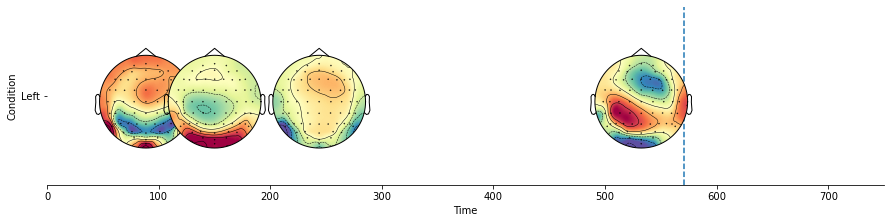

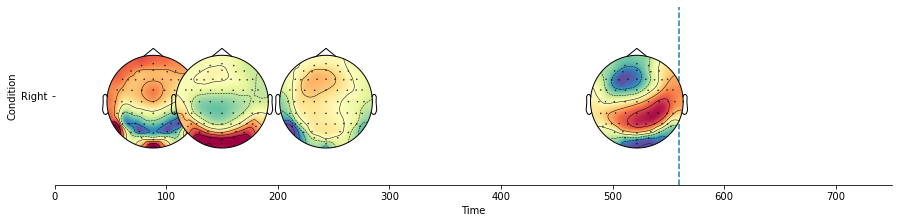

In [12]:
for condition in zip([left_stim, right_stim],
                     [init_l, init_r],
                     [hsmm_l_data, hsmm_r_data],
                    ['Left', 'Right']):
    electrodes = xr.DataArray(hsmm.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.plot_topo_timecourse(electrodes, condition[1].mean_bump_times(condition[0].eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(15,3), ylabels={'Condition':[condition[3]]})

# Estimating separate stage duration for speed and accuracy

In [13]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.stack_data(subset,'participant')
init_speed = hsmm.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.stack_data(subset,'participant')
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [ ]:
speed = init_speed.fit_single(4, magnitudes=bests.sel(n_bumps=4).magnitudes)
accuracy = init_accuracy.fit_single(4, magnitudes=bests.sel(n_bumps=4).magnitudes)

Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 4 bumps model


In [ ]:
for condition in zip([speed, accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = xr.DataArray(hsmm.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.plot_topo_timecourse(electrodes, condition[1].mean_bump_times(condition[0].eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(15,3), ylabels={'Condition':[condition[3]]})

# Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [ ]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.stack_data(subset,'participant')
init_speed = hsmm.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [ ]:
bests_speed = init_speed.backward_estimation(max_starting_points=20)
bests_speed

## Plotting the bump placement from this method

In [ ]:
electrodes = xr.DataArray(hsmm.reconstruct(bests_speed.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.plot_topo_timecourse(electrodes, init_speed.mean_bump_times(bests_speed.eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(hsmm_speed_data.ends.data - hsmm_speed_data.starts.data), 
                          figsize=(15,10), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

In [ ]:
temp = hsmm_speed_data.unstack().data
bests = bests_speed
init = init_speed

subjects_idx = epoch_data.participant.values
likelihoods_loo = []
all_n_bumps = []
for n_bumps in np.arange(1,init_speed.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})
loocv_speed=loocv

Plotting LOOCV along with pvalues from the sign test

In [ ]:
hsmm.plot_LOOCV(loocv_speed)

# Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [ ]:
subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.stack_data(subset,'participant')
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

In [ ]:
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [ ]:
bests_accuracy = init_accuracy.backward_estimation(max_starting_points=20)
bests_accuracy

## Plotting the bump placement from this method

In [ ]:
electrodes = xr.DataArray(hsmm.reconstruct(bests_accuracy.magnitudes, PCs, 
                            explained_var, means))

hsmm.plot_topo_timecourse(electrodes, init_accuracy.mean_bump_times(bests_accuracy.eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=init_accuracy.bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(hsmm_accuracy_data.ends.data - hsmm_accuracy_data.starts.data), 
                          figsize=(15,10), ylabels={'Number of bumps':np.arange(init_accuracy.max_bumps)+1})

In [ ]:
temp = hsmm_accuracy_data.unstack().data
bests = bests_accuracy
init = init_accuracy

subjects_idx = epoch_data.participant.values
likelihoods_loo = []
all_n_bumps = []
for n_bumps in np.arange(1,init.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)

loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

loocv_accuracy = loocv

In [ ]:
hsmm.plot_LOOCV(loocv_accuracy)

# Inspecting best model

In [ ]:
estimates_speed = bests_speed.sel(n_bumps=3).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=4).drop_vars('n_bumps')

### Bump probabilities

In [ ]:
bumps = [0,1,2]
colors = ['cornflowerblue','indianred','darkblue']
for bump in bumps:
    plt.plot(estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=bump),'--', label="Speed Bump "+str(bump), color=colors[bump])
bumps = [0,1,2,3]
colors = ['cornflowerblue','indianred','orange','darkblue']
for bump in bumps:
    plt.plot(estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=bump), label="Accuracy Bump "+str(bump), color=colors[bump])
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)')
plt.xlim(0,100)
plt.legend();

### Gamma distribution of stages

In [ ]:
f, axs = plt.subplots(1,1, figsize=(6, 4),sharey=True, sharex=False,dpi=100)

cond = ['Speed', 'Accuracy']
color_spd = ['gray','cornflowerblue','indianred','darkblue']
color_acc = ['gray','cornflowerblue','indianred','orange','darkblue']
stages_accuracy = estimates_accuracy.parameters.isel(params=0).dropna('stage') * estimates_accuracy.parameters.isel(params=1).dropna('stage')+[0,5,5,5,5]
stages_speed = estimates_speed.parameters.isel(params=0).dropna('stage') * estimates_speed.parameters.isel(params=1).dropna('stage')+[0,5,5,5]

j = 0
for i in np.arange(len(stages_accuracy),0,-1):
    plt.barh(.5, stages_accuracy[:i].sum(), color=color_acc[i-1], edgecolor='k')
    if i <= len(stages_speed):
        plt.barh(-.5, stages_speed[:i].sum(), color=color_spd[i-1], edgecolor='k')
    j-=1
plt.yticks([-.5,.5],["Speed","Accuracy"])
plt.xlabel('(Cumulative) Stages durations from stimulus onset (samples)')
plt.tight_layout()
plt.show()

### Topography of bumps

In [ ]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = xr.DataArray(hsmm.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.plot_topo_timecourse(electrodes, condition[1].mean_bump_times(condition[0].eventprobs),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 10, magnify=1, 
                          mean_rt = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(15,3), ylabels={'Condition':[condition[3]]})
